# Clustering Methods Comparison Plots

This notebook generates comparison plots for 4 clustering methods:
- HDBSCAN
- Graph Clustering (GC)
- Manual Review
- Thresholded Review

Metrics plotted:
- F1 Score vs Number of Human Reviews
- Precision vs Number of Human Reviews
- Recall vs Number of Human Reviews
- Fraction Correct vs Number of Human Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define colors for each method
METHOD_COLORS = {
    'HDBSCAN': '#1f77b4',
    'GC': '#ff7f0e',
    'Manual Review': '#2ca02c',
    'Thresholded Review': '#d62728'
}

In [2]:
# Configuration - UPDATE THESE PATHS
SPECIES = 'whaleshark'  # Change this to the species you want to analyze
name_field = 'name'
BASE_PATH = Path('/fs/ess/PAS2136/ggr_data/results/kate')
TMP_PATH = Path('/users/PAS2136/nepove/code/lca/lca/tmp')

PLOT_PATH = BASE_PATH / SPECIES / 'plots' 

PLOT_PATH.mkdir(parents=True, exist_ok=True)

# Define log file paths for each method
LOG_PATHS = {
    'HDBSCAN': TMP_PATH / SPECIES / 'output' / 'hdbscan_output.log',
    'GC': TMP_PATH / SPECIES / 'output' / 'gc_output_theta_01_metadata.log',
    'Manual Review': TMP_PATH / SPECIES / 'output' / 'manual_review_output.log',
    'Thresholded Review': TMP_PATH / SPECIES / 'output' / 'thresholded_review_output.log'
}

print(f"Analyzing species: {SPECIES}")
print("\nChecking for log files:")
for method, path in LOG_PATHS.items():
    exists = path.exists() if path else False
    print(f"{method}: {'✓' if exists else '✗'} {path}")

Analyzing species: whaleshark

Checking for log files:
HDBSCAN: ✓ /users/PAS2136/nepove/code/lca/lca/tmp/whaleshark/output/hdbscan_output.log
GC: ✓ /users/PAS2136/nepove/code/lca/lca/tmp/whaleshark/output/gc_output_theta_01_metadata.log
Manual Review: ✓ /users/PAS2136/nepove/code/lca/lca/tmp/whaleshark/output/manual_review_output.log
Thresholded Review: ✓ /users/PAS2136/nepove/code/lca/lca/tmp/whaleshark/output/thresholded_review_output.log


In [3]:
import re

def parse_log_file(filepath, method):
    """Parse metrics from log files"""
    if not filepath.exists():
        print(f"Warning: Log file not found: {filepath}")
        return None
    
    with open(filepath, 'r') as f:
        content = f.read()
    
    metrics_data = []
    
    if method == 'HDBSCAN':
        # Parse final metrics from HDBSCAN log
        # Look for pattern like "F1 Score:         0.5656"
        f1_match = re.search(r'F1 Score:\s+([\d.]+)', content)
        precision_match = re.search(r'Precision:\s+([\d.]+)', content)
        recall_match = re.search(r'Recall:\s+([\d.]+)', content)
        fraccorrect_match = re.search(r'Fraction Correct:\s+([\d.]+)', content)

        if f1_match and precision_match and recall_match:
            metrics_data.append({
                'num_human_reviews': 0,
                'f1_score': float(f1_match.group(1)),
                'precision': float(precision_match.group(1)),
                'recall': float(recall_match.group(1)),
                'frac_correct': float(fraccorrect_match.group(1))  # Calculate if available
            })
    
    elif method == 'GC':
        # Parse GC log - ONLY extract Basic Stats, ignore Reachable Stats
        # Look for Basic stats blocks
        basic_stats_blocks = re.findall(
            r'Basic stats:.*?\{(.*?)\}', 
            content, 
            re.DOTALL | re.IGNORECASE
        )
        
        for block in basic_stats_blocks:
            # Extract metrics from each Basic stats block
            num_human_match = re.search(r'"num human":\s*(\d+)', block)
            f1_match = re.search(r'"f1 score":\s*([\d.]+)', block)
            precision_match = re.search(r'"precision":\s*([\d.]+)', block)
            recall_match = re.search(r'"recall":\s*([\d.]+)', block)
            frac_correct_match = re.search(r'"frac correct":\s*([\d.]+)', block)
            
            if num_human_match and f1_match and precision_match and recall_match:
                metrics_data.append({
                    'num_human_reviews': int(num_human_match.group(1)),
                    'f1_score': float(f1_match.group(1)),
                    'precision': float(precision_match.group(1)),
                    'recall': float(recall_match.group(1)),
                    'frac_correct': float(frac_correct_match.group(1)) if frac_correct_match else 0.0
                })
        
        # Sort by num_human_reviews to ensure correct order
        metrics_data.sort(key=lambda x: x['num_human_reviews'])
    
    elif method == 'Manual Review':
        # Parse Manual Review log - specific format
        # Pattern: "Evaluation Metrics - FULL DATASET (after XXX reviews):"
        # Followed by F1, Precision, Recall, Fraction Correct lines
        
        # Find all evaluation blocks
        eval_pattern = r'Evaluation Metrics - FULL DATASET \(after (\d+) reviews\):.*?F1 Score:\s*([\d.]+).*?Precision:\s*([\d.]+).*?Recall:\s*([\d.]+).*?Fraction Correct:\s*([\d.]+)'
        
        matches = re.findall(eval_pattern, content, re.DOTALL)
        
        for match in matches:
            metrics_data.append({
                'num_human_reviews': int(match[0]),
                'f1_score': float(match[1]),
                'precision': float(match[2]),
                'recall': float(match[3]),
                'frac_correct': float(match[4])
            })
        
        # Sort by num_human_reviews
        metrics_data.sort(key=lambda x: x['num_human_reviews'])
    
    elif method == 'Thresholded Review':
        # Parse Thresholded Review log
        # First try the same pattern as Manual Review
        eval_pattern = r'Evaluation Metrics.*?\(after (\d+) reviews\):.*?F1 Score:\s*([\d.]+).*?Precision:\s*([\d.]+).*?Recall:\s*([\d.]+).*?Fraction Correct:\s*([\d.]+)'
        
        matches = re.findall(eval_pattern, content, re.DOTALL)
        
        if matches:
            for match in matches:
                metrics_data.append({
                    'num_human_reviews': int(match[0]),
                    'f1_score': float(match[1]),
                    'precision': float(match[2]),
                    'recall': float(match[3]),
                    'frac_correct': float(match[4])
                })
        else:
            # Try alternative patterns
            # Pattern for iteration-based metrics
            iter_pattern = r'Iteration\s+\d+.*?Human reviews:\s*(\d+).*?F1.*?:\s*([\d.]+).*?Precision.*?:\s*([\d.]+).*?Recall.*?:\s*([\d.]+)'
            matches = re.findall(iter_pattern, content, re.DOTALL | re.IGNORECASE)
            
            if matches:
                for match in matches:
                    metrics_data.append({
                        'num_human_reviews': int(match[0]),
                        'f1_score': float(match[1]),
                        'precision': float(match[2]),
                        'recall': float(match[3]),
                        'frac_correct': 0.0  # Not available in this format
                    })
            else:
                # Get final metrics only
                f1_match = re.search(r'F1 Score:\s+([\d.]+)', content)
                precision_match = re.search(r'Precision:\s+([\d.]+)', content)
                recall_match = re.search(r'Recall:\s+([\d.]+)', content)
                
                if f1_match and precision_match and recall_match:
                    # Create a single point with final metrics
                    metrics_data.append({
                        'num_human_reviews': 250,  # Typical for thresholded
                        'f1_score': float(f1_match.group(1)),
                        'precision': float(precision_match.group(1)),
                        'recall': float(recall_match.group(1)),
                        'frac_correct': 0.0
                    })
        
        # Sort by num_human_reviews
        metrics_data.sort(key=lambda x: x['num_human_reviews'])
    
    return pd.DataFrame(metrics_data) if metrics_data else None

In [4]:
# Load metrics from log files
metrics_dfs = {}

for method, path in LOG_PATHS.items():
    print(f"\nParsing {method} log...")
    df = parse_log_file(path, method)
    
    if df is not None and not df.empty:
        metrics_dfs[method] = df
        print(f"  Extracted {len(df)} data points")
        print(f"  Human reviews range: {df['num_human_reviews'].min()} - {df['num_human_reviews'].max()}")
        print(f"  F1 Score range: {df['f1_score'].min():.3f} - {df['f1_score'].max():.3f}")
    else:
        print(f"  No metrics extracted")

# If we have real data from logs, use it. Otherwise fall back to synthetic
if metrics_dfs:
    print("\n✓ Successfully loaded metrics from log files")
else:
    print("\n⚠️ No metrics could be extracted from logs. Using synthetic data...")


Parsing HDBSCAN log...
  Extracted 1 data points
  Human reviews range: 0 - 0
  F1 Score range: 0.011 - 0.011

Parsing GC log...
  Extracted 7 data points
  Human reviews range: 0 - 1151
  F1 Score range: 0.017 - 0.593

Parsing Manual Review log...
  Extracted 50 data points
  Human reviews range: 100 - 5000
  F1 Score range: 0.081 - 0.337

Parsing Thresholded Review log...
  Extracted 50 data points
  Human reviews range: 100 - 5000
  F1 Score range: 0.166 - 0.320

✓ Successfully loaded metrics from log files


In [5]:
# Generate synthetic data for demonstration if real data is not available
def generate_synthetic_data():
    """Generate synthetic data for demonstration purposes"""
    np.random.seed(42)
    
    # HDBSCAN - constant performance (no human reviews)
    hdbscan_df = pd.DataFrame([{
        'num_human_reviews': 0,
        'f1_score': 0.75,
        'precision': 0.78,
        'recall': 0.72,
        'frac_correct': 0.76
    }])
    
    # GC - improves with human reviews
    num_reviews_gc = np.arange(0, 1001, 100)
    gc_df = pd.DataFrame({
        'num_human_reviews': num_reviews_gc,
        'f1_score': 0.65 + 0.25 * (1 - np.exp(-num_reviews_gc/300)),
        'precision': 0.68 + 0.22 * (1 - np.exp(-num_reviews_gc/300)),
        'recall': 0.62 + 0.28 * (1 - np.exp(-num_reviews_gc/300)),
        'frac_correct': 0.66 + 0.24 * (1 - np.exp(-num_reviews_gc/300))
    })
    
    # Manual Review - linear improvement
    num_reviews_manual = np.arange(0, 1001, 50)
    manual_df = pd.DataFrame({
        'num_human_reviews': num_reviews_manual,
        'f1_score': np.minimum(0.5 + num_reviews_manual * 0.0004, 0.92),
        'precision': np.minimum(0.52 + num_reviews_manual * 0.00038, 0.90),
        'recall': np.minimum(0.48 + num_reviews_manual * 0.00042, 0.94),
        'frac_correct': np.minimum(0.51 + num_reviews_manual * 0.0004, 0.91)
    })
    
    # Thresholded Review - faster initial improvement
    num_reviews_thresh = np.arange(0, 501, 25)
    thresh_df = pd.DataFrame({
        'num_human_reviews': num_reviews_thresh,
        'f1_score': 0.70 + 0.22 * (1 - np.exp(-num_reviews_thresh/150)),
        'precision': 0.73 + 0.19 * (1 - np.exp(-num_reviews_thresh/150)),
        'recall': 0.67 + 0.25 * (1 - np.exp(-num_reviews_thresh/150)),
        'frac_correct': 0.71 + 0.21 * (1 - np.exp(-num_reviews_thresh/150))
    })
    
    return {
        'HDBSCAN': hdbscan_df,
        'GC': gc_df,
        'Manual Review': manual_df,
        'Thresholded Review': thresh_df
    }

# Use synthetic data if no real data is loaded
if not metrics_dfs:
    print("\n⚠️ No real data found. Using synthetic data for demonstration...")
    metrics_dfs = generate_synthetic_data()

In [6]:
def create_metric_plot(metric_name, ylabel, title_suffix=""):
    """Create a plot for a specific metric across all methods"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for method, df in metrics_dfs.items():
        if df is not None and metric_name in df.columns:
            if method == 'HDBSCAN':
                # HDBSCAN: draw a horizontal line across the entire x-axis
                max_reviews = max([d['num_human_reviews'].max() for m, d in metrics_dfs.items() 
                                 if m != 'HDBSCAN' and d is not None])
                ax.axhline(y=df[metric_name].iloc[0], 
                          color=METHOD_COLORS[method], 
                          linestyle='--', 
                          linewidth=2, 
                          label=f'{method} (no human review)',
                          alpha=0.8)
            else:
                # Other methods: plot as lines
                ax.plot(df['num_human_reviews'], 
                       df[metric_name], 
                       marker='o', 
                       markersize=6,
                       linewidth=2,
                       label=method, 
                       color=METHOD_COLORS[method],
                       alpha=0.8)
    
    ax.set_xlabel('Number of Human Reviews', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_title(f'{ylabel} vs Number of Human Reviews{title_suffix}', 
                fontsize=16, fontweight='bold', pad=20)
    
    ax.legend(loc='best', fontsize=12, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Set y-axis limits
    ax.set_ylim([0, 1.05])
    
    # Add minor gridlines
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.1, linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    return fig

## F1 Score vs Number of Human Reviews

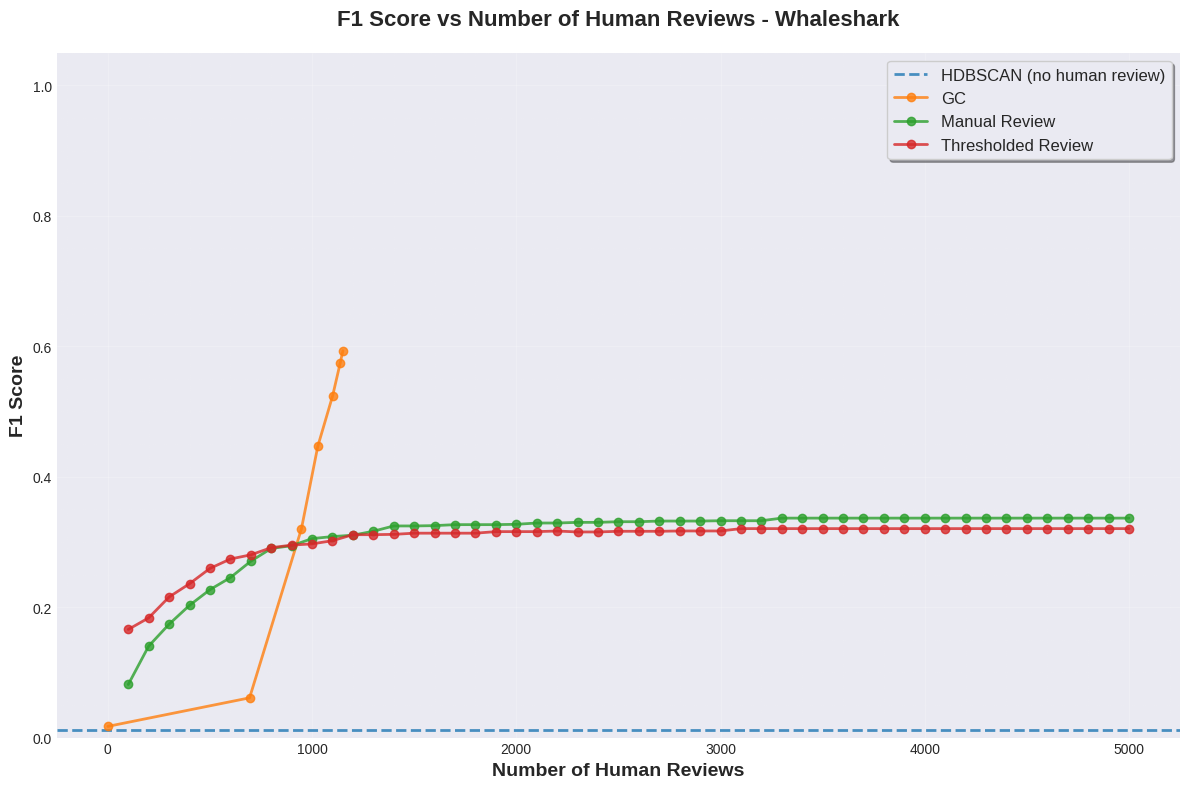

In [7]:
# Plot 1: F1 Score
fig1 = create_metric_plot('f1_score', 'F1 Score', f' - {SPECIES.capitalize()}')
plt.savefig(f'{PLOT_PATH}/{SPECIES}_f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Precision vs Number of Human Reviews

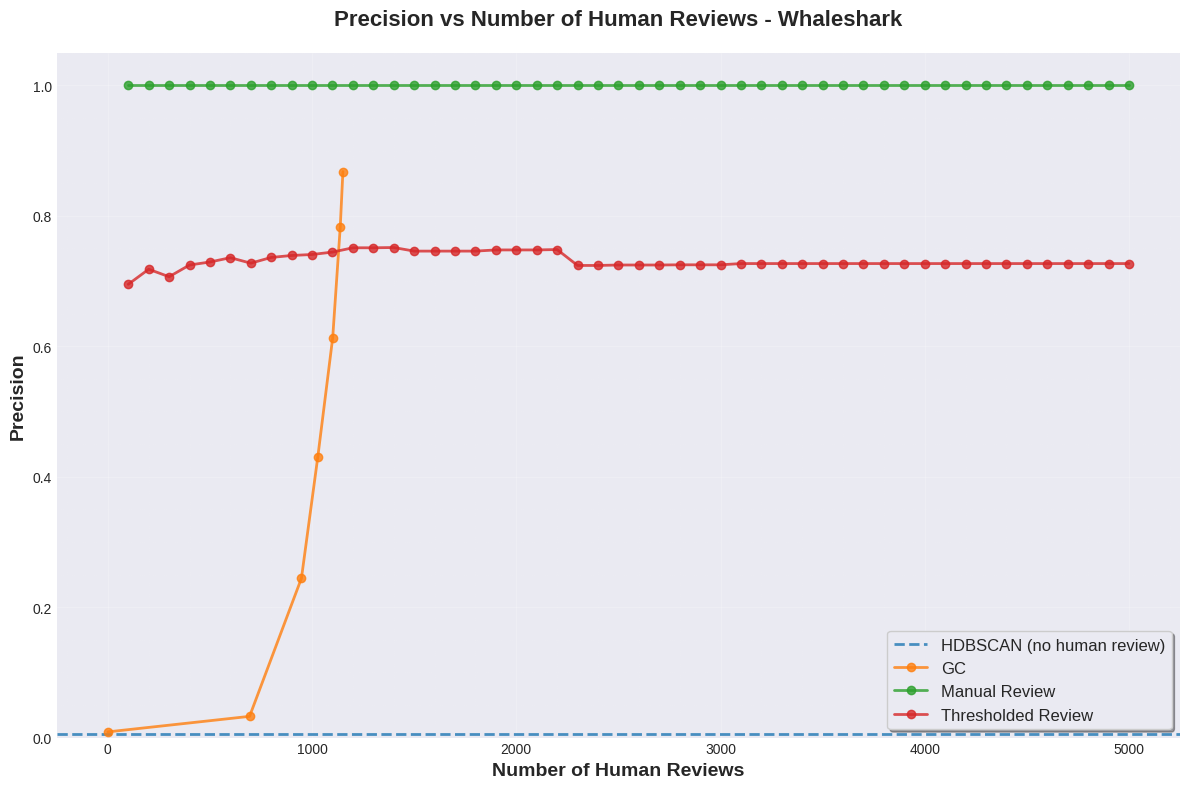

In [8]:
# Plot 2: Precision
fig2 = create_metric_plot('precision', 'Precision', f' - {SPECIES.capitalize()}')
plt.savefig(f'{PLOT_PATH}/{SPECIES}_precision_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Recall vs Number of Human Reviews

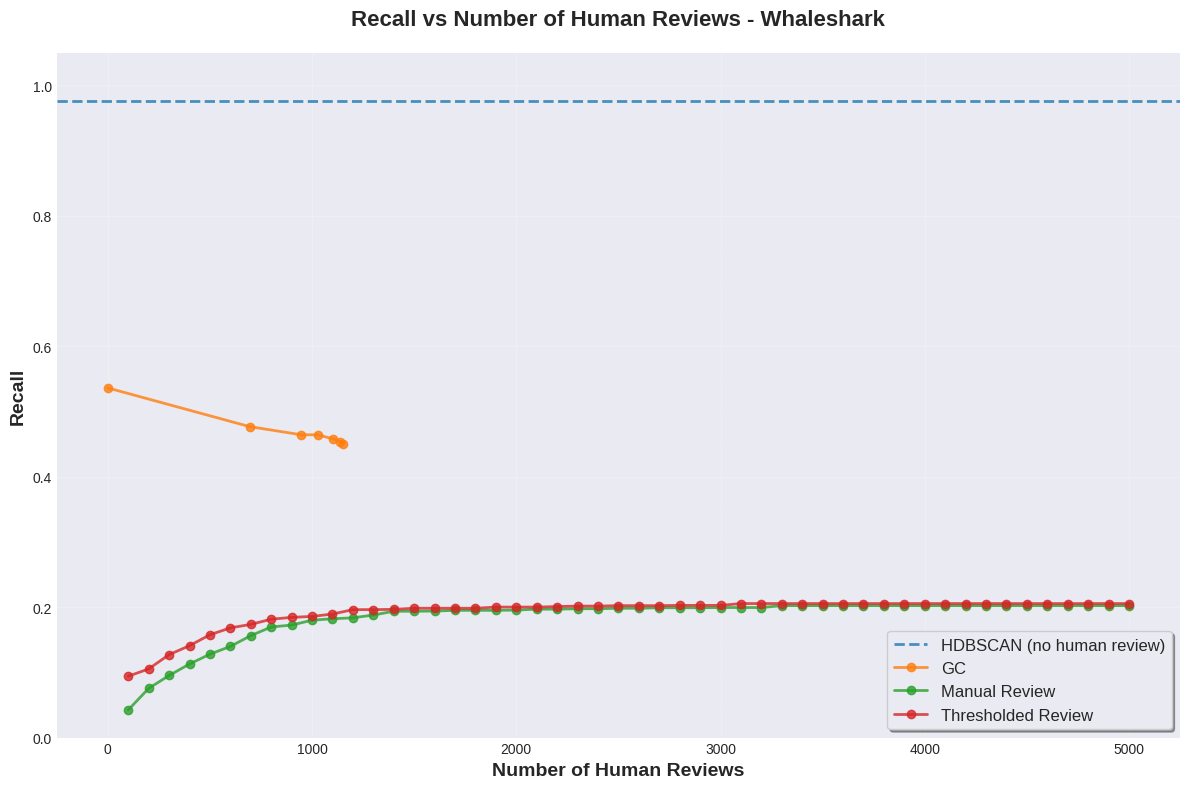

In [9]:
# Plot 3: Recall
fig3 = create_metric_plot('recall', 'Recall', f' - {SPECIES.capitalize()}')
plt.savefig(f'{PLOT_PATH}/{SPECIES}_recall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Fraction Correct vs Number of Human Reviews

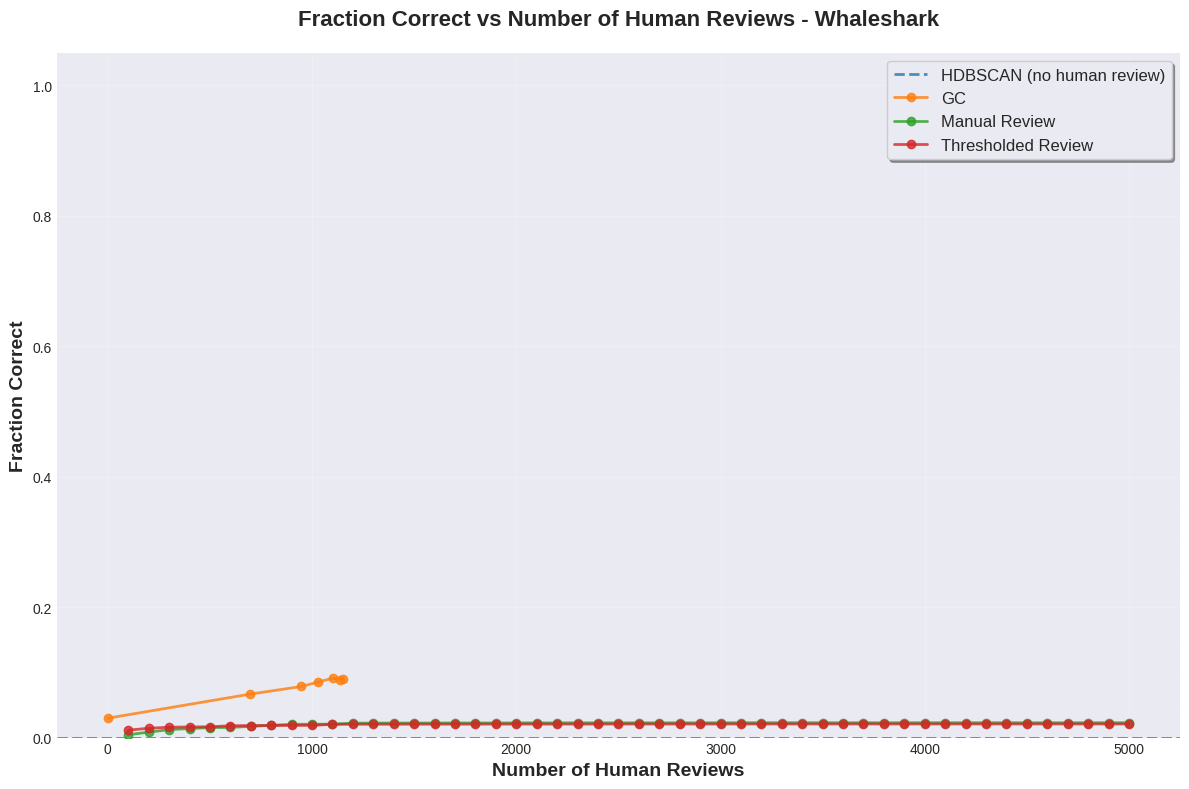

In [10]:
# Plot 4: Fraction Correct
fig4 = create_metric_plot('frac_correct', 'Fraction Correct', f' - {SPECIES.capitalize()}')
plt.savefig(f'{PLOT_PATH}/{SPECIES}_frac_correct_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Combined Metrics Summary

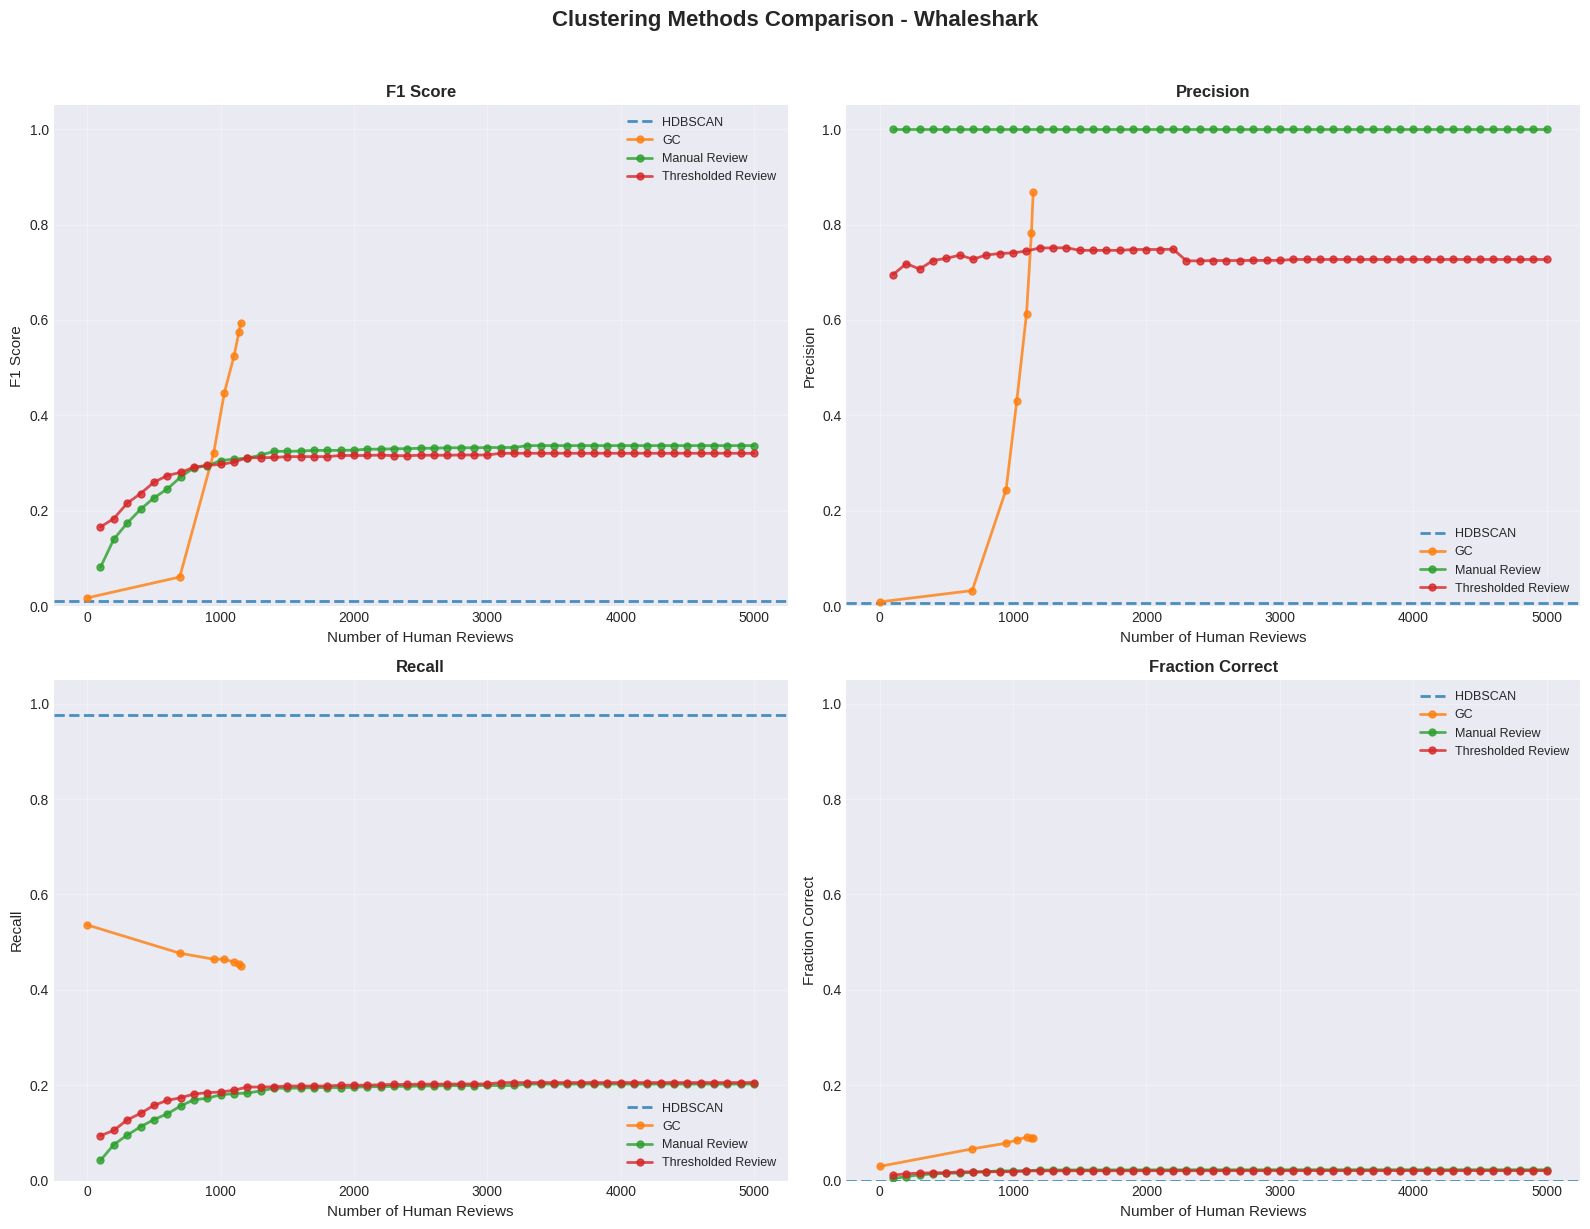

In [11]:
# Create a combined plot with all metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['f1_score', 'precision', 'recall', 'frac_correct']
ylabels = ['F1 Score', 'Precision', 'Recall', 'Fraction Correct']

for idx, (ax, metric, ylabel) in enumerate(zip(axes.flatten(), metrics, ylabels)):
    for method, df in metrics_dfs.items():
        if df is not None and metric in df.columns:
            if method == 'HDBSCAN':
                max_reviews = max([d['num_human_reviews'].max() for m, d in metrics_dfs.items() 
                                 if m != 'HDBSCAN' and d is not None])
                ax.axhline(y=df[metric].iloc[0], 
                          color=METHOD_COLORS[method], 
                          linestyle='--', 
                          linewidth=2, 
                          label=f'{method}',
                          alpha=0.8)
            else:
                ax.plot(df['num_human_reviews'], 
                       df[metric], 
                       marker='o', 
                       markersize=5,
                       linewidth=2,
                       label=method, 
                       color=METHOD_COLORS[method],
                       alpha=0.8)
    
    ax.set_xlabel('Number of Human Reviews', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(ylabel, fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

fig.suptitle(f'Clustering Methods Comparison - {SPECIES.capitalize()}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PLOT_PATH}/{SPECIES}_all_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

In [12]:
# Export data to CSV for further analysis
for method, df in metrics_dfs.items():
    if df is not None:
        filename = f"{PLOT_PATH}/{SPECIES}_{method.lower().replace(' ', '_')}_metrics.csv"
        df.to_csv(filename, index=False)
        print(f"Exported {method} data to {filename}")

Exported HDBSCAN data to /fs/ess/PAS2136/ggr_data/results/kate/whaleshark/plots/whaleshark_hdbscan_metrics.csv
Exported GC data to /fs/ess/PAS2136/ggr_data/results/kate/whaleshark/plots/whaleshark_gc_metrics.csv
Exported Manual Review data to /fs/ess/PAS2136/ggr_data/results/kate/whaleshark/plots/whaleshark_manual_review_metrics.csv
Exported Thresholded Review data to /fs/ess/PAS2136/ggr_data/results/kate/whaleshark/plots/whaleshark_thresholded_review_metrics.csv
